The goal of this notebook is to study the current increase of house prices in Dublin and to understand what is driving this increase. Specifically, we wish to answer the question as to whether this is another housing bubble or not.

Firstly, we shall attempt to model the average house price in Dublin based purely on the number of (occupied) properties per capita. Secondly, we shall use the 5 criteria listed in 'https://www.forbes.com/sites/trulia/2016/11/15/signs-your-local-real-estate-market-is-a-bubble/#4d7f62397744' to check whether or not the current market in Dublin is a housing bubble or not. We shall also check the 'Celtic Tiger' housing bubble of the late 1990s in Dublin as a control.

# Plotting the average property price by year

In [14]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm

We now read in 2 Excel files; the first contains the average new house price by area and year and the second contains the average second-hand house price by area and year. We obtained this data from 'http://www.housing.gov.ie/housing/statistics/house-prices-loans-and-profile-borrowers/house-price-statistics'. We note that this data is based on mortgages approved, i.e. it excludes cash transactions.

In [3]:
#specify the filenames
filenames = ['n_price_yr.xlsx', 'sh_price_yr.xlsx']

#build a list comprehension of dataframes
dataframes = [pd.read_excel(file, header=1, index_col=0) for file in filenames]

#strip whitespace
dataframes = [df.rename(columns=lambda x: x.strip()) for df in dataframes]
#keep only the Dublin column
dataframes = [pd.DataFrame(df.Dublin) for df in dataframes]

#modify the column header to clarify whether we are talking about new or second-hand properties
for n in range(len(dataframes)):
    #modify the column headers
    dataframes[n].columns = dataframes[n].columns + '_' + filenames[n][0]
    #convert the indices to strings
    dataframes[n].index = dataframes[n].index.map(str)
    
#we remove these last 6 unwanted rows and convert the prices to thousands of €
dataframes = [df.loc['1974':'2015'] / 1000 for df in dataframes]

#we now merge the two dataframes.
df_c = pd.concat(dataframes, axis=1, join='inner')

We now plot, for both the new and second-hand data, the average house prices over time.

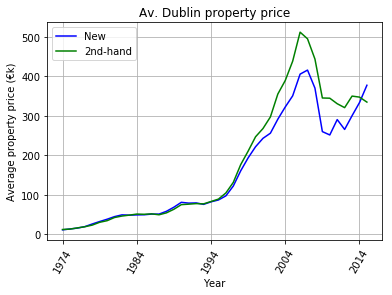

In [6]:
plt.plot(df_c.Dublin_n.values, label='New', c='b')
plt.plot(df_c.Dublin_s.values, label='2nd-hand', c='g')

plt.title('Av. Dublin property price')
plt.ylabel('Average property price (€k)')
plt.xlabel('Year')

plt.xticks(range(0, len(df_c), 10), df_c.index.tolist()[::10], rotation=60)

plt.legend()
plt.grid()

plt.show()

We now plot the rate of change of the property prices, by year.  We then plot smoothed versions of this data.

C:\Users\Michael\Anaconda3\lib\site-packages\ipykernel\__main__.py:18: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
C:\Users\Michael\Anaconda3\lib\site-packages\ipykernel\__main__.py:19: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version


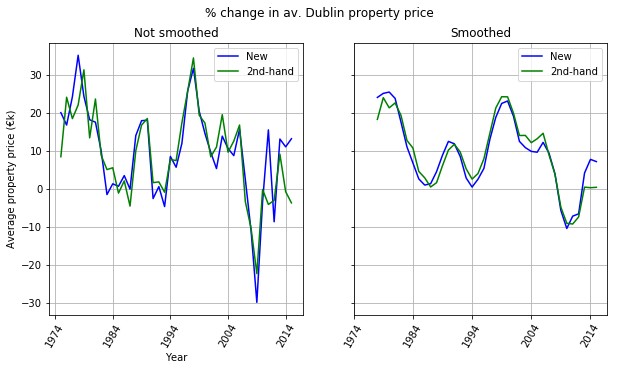

In [7]:
#define % change
roc_df = df_c.pct_change() * 100

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10, 5))

plt.suptitle('% change in av. Dublin property price')

ax1.plot(roc_df.Dublin_n.values, label='New', c='b')
ax1.plot(roc_df.Dublin_s.values, label='2nd-hand', c='g')
ax1.set_title('Not smoothed')
ax1.legend()
ax1.set_ylabel('Average property price (€k)')
ax1.set_xlabel('Year')
ax1.set_xticks(range(0, len(roc_df), 10))
ax1.set_xticklabels(roc_df.index.tolist()[::10], rotation=60)
ax1.grid()

ax2.plot(np.array(pd.rolling_mean(roc_df.Dublin_n.values, window=4)), label='New', c='b')
ax2.plot(np.array(pd.rolling_mean(roc_df.Dublin_s.values, window=4)), label='2nd-hand', c='g')
ax2.set_title('Smoothed')
ax2.legend()
ax1.set_xlabel('Year')
ax2.set_xticks(range(0, len(roc_df), 10))
ax2.set_xticklabels(roc_df.index.tolist()[::10], rotation=60)
ax2.grid()

plt.show()

# Plotting property price vs. households/capita

The government has declared that the current increase in property prices is driven by a shortage of houses. We will investigate this by predicting house prices using the number of residences per capita.

As a control, we shall first see how this fares for the 'Celtic Tiger' period. We now read in data on the numbers of households in Dublin. This data was obtained from 'http://www.cso.ie/px/pxeirestat/statire/SelectVarVal/Define.asp?Maintable=CNA33&Planguage=0'. We also read in population data, obtained from 'http://www.cso.ie/px/pxeirestat/statire/SelectVarVal/Define.asp?MainTable=A0102&PLanguage=0&PXSId=0'.

In [8]:
#read in the CSV files
households, pop = pd.read_csv('households.csv', skiprows=3), pd.read_csv('pop.csv', skiprows=2)
#select the relevant data
households, pop = households.iloc[2], pop.iloc[3, 2:]
#omit missing data
households = households[households != '..'].iloc[3:]

#define a house per capita dataframe
house_pc = (pop / households).dropna().astype('float64')

#append this to the df_c dataframe
df_c['house_pc'] = house_pc

#display the first 10 rows of df_c
df_c.head(10)

,Dublin_n,Dublin_s,house_pc
1974,10.942603,11.776821,NaN
1975,13.136710,12.773565,NaN
1976,15.342245,15.850140,NaN
1977,19.054959,18.778156,NaN
1978,25.745209,22.920042,NaN
1979,32.005018,30.091523,3.754286
1980,37.821688,34.129290,NaN
1981,44.456070,42.193396,3.702655
1982,48.886186,45.912459,NaN
1983,48.168784,48.248777,NaN


## Filling in the 'missing' values

It is clear that we are 'missing' many values for the house_pc column. This is due to the fact that data is only available for census years. We would like to fill in these values: let us begin by plotting the properties per capita by year.

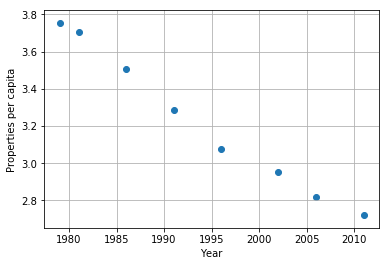

In [9]:
#drop the null values
df_cfin = df_c.dropna()

plt.scatter(x=df_cfin.index.values.astype('int'), y=df_cfin.house_pc.values)
plt.xlabel('Year'), plt.ylabel('Properties per capita')
plt.grid()

plt.show()

This looks highly linear. As such, let us fit this using linear regression. We print the r^2 score for the fit and display the fit on a plot.

0.986165165641


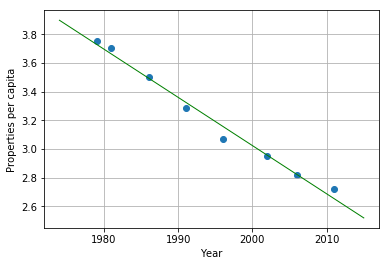

In [10]:
#drop the null values
df_cfin = df_c.dropna()

#initiate LinearRegression()
reg = LinearRegression()
#define the predictors and response
X, y = df_cfin.index.values.astype('int').reshape(-1,1), df_cfin.house_pc
#fit the regression model
reg.fit(X, y)

#define a prediction space
prediction_space = np.arange(1974, 2016).reshape(-1,1)
#obtain the predictions of the regression model for the response
y_pred = reg.predict(prediction_space)
#print the r^2 score of the model
print(reg.score(X, y))

#plot the model and the data points
plt.scatter(x=df_cfin.index.values.astype('int'), y=df_cfin.house_pc.values)
plt.plot(prediction_space, y_pred, color='green', linewidth=1)
plt.xlabel('Year'), plt.ylabel('Properties per capita')
plt.grid()

plt.show()

This is a very good fit. We now use this regression fit to obtain values for the 'missing' years in the df_c dataframe.

In [11]:
y_pred_df = pd.DataFrame(y_pred, columns=['house_pc_int'])
y_pred_df = y_pred_df.set_index(df_c.index)

#fill in the missing values and assign it as a column in df_c
df_c['house_pc_fill'] = df_c['house_pc'].fillna(y_pred_df.house_pc_int, axis=0)

We now plot the house prices in Dublin versus the properties per capits in Dublin and fit them using a linear regression model again.

C:\Users\Michael\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  app.launch_new_instance()
C:\Users\Michael\Anaconda3\lib\site-packages\ipykernel\__main__.py:20: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


0.822846095266
0.785754493849


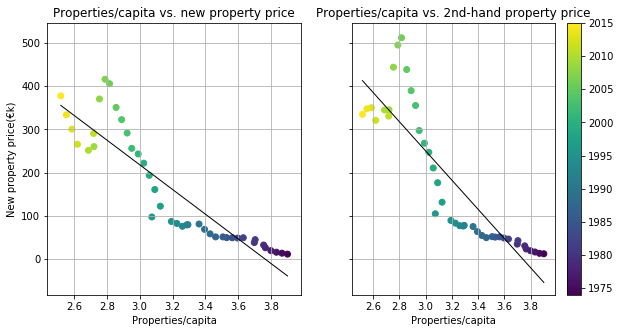

In [53]:
lin_reg = LinearRegression()

X, y = df_c.house_pc_fill.reshape(-1, 1), df_c.Dublin_n.reshape(-1, 1)

lin_reg.fit(X, y)

prediction_space = np.linspace(min(X), max(X)).reshape(-1,1)
y_pred = lin_reg.predict(prediction_space)
print(lin_reg.score(X, y))

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10, 5))

ax1.scatter(x=df_c.house_pc_fill, y=df_c.Dublin_n, c=df_c.index)
ax1.plot(prediction_space, y_pred, color='black', linewidth=1)
ax1.set_xlabel('Properties/capita')
ax1.set_ylabel('New property price(€k)')
ax1.set_title('Properties/capita vs. new property price')
ax1.grid()

X, y = df_c.house_pc_fill.reshape(-1, 1), df_c.Dublin_s.reshape(-1, 1)

lin_reg.fit(X, y)

prediction_space = np.linspace(min(X), max(X)).reshape(-1,1)
y_pred = lin_reg.predict(prediction_space)
print(lin_reg.score(X, y))

im = ax2.scatter(x=df_c.house_pc_fill, y=df_c.Dublin_s, c=df_c.index)
ax2.plot(prediction_space, y_pred, color='black', linewidth=1)
ax2.set_xlabel('Properties/capita')
ax2.set_title('Properties/capita vs. 2nd-hand property price')
ax2.set_xticks(np.arange(2.6, 4, 0.2))
#ax2.set_xticklabels(df_c.house_pc_fill.tolist()[::1])
ax2.grid()

f.colorbar(im)

plt.show()

This isn't the best fit. There appear to be multiple 'phases', however, in which the relationship could be modelled well with a linear model. There are 2 avenues which I will pursue:

* splitting up these 'phases' and considering them separately
* fitting with a higher order polynomial (rather than a linear polynomial)

## Polynomial fit

C:\Users\Michael\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
C:\Users\Michael\Anaconda3\lib\site-packages\ipykernel\__main__.py:21: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


0.963777082006
0.964415153665


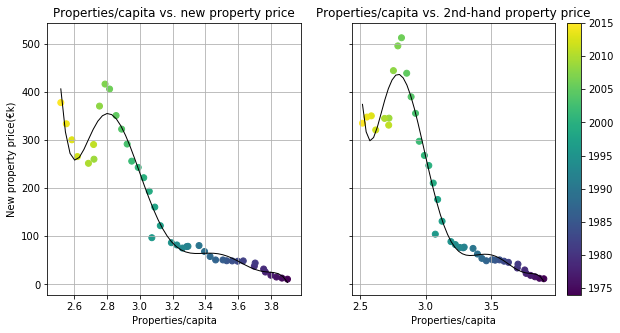

In [28]:
poly = PolynomialFeatures(degree=7)
lin_reg = LinearRegression()

X, y = df_c.house_pc_fill.reshape(-1, 1), df_c.Dublin_n.reshape(-1, 1)

lin_reg.fit(poly.fit_transform(X), y)

prediction_space = np.linspace(min(X), max(X)).reshape(-1,1)
y_pred = lin_reg.predict(poly.fit_transform(prediction_space))
print(lin_reg.score(poly.fit_transform(X), y))

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10, 5))

im = ax1.scatter(x=df_c.house_pc_fill, y=df_c.Dublin_n, c=df_c.index)
ax1.plot(prediction_space, y_pred, color='black', linewidth=1)
ax1.set_xlabel('Properties/capita')
ax1.set_ylabel('New property price(€k)')
ax1.set_title('Properties/capita vs. new property price')
ax1.grid()

X, y = df_c.house_pc_fill.reshape(-1, 1), df_c.Dublin_s.reshape(-1, 1)

lin_reg.fit(poly.fit_transform(X), y)

prediction_space = np.linspace(min(X), max(X)).reshape(-1,1)
y_pred = lin_reg.predict(poly.fit_transform(prediction_space))
print(lin_reg.score(poly.fit_transform(X), y))

ax2.scatter(x=df_c.house_pc_fill, y=df_c.Dublin_s, c=df_c.index)
ax2.plot(prediction_space, y_pred, color='black', linewidth=1)
ax2.set_xlabel('Properties/capita')
ax2.set_title('Properties/capita vs. 2nd-hand property price')
ax2.grid()

f.colorbar(im)

plt.show()

These are good fits, yet, due to the small dataset, there is a good chance that we are overfitting the data. Also, even if this were the 'correct' fit, it is hard to interpret the fit.

## Splitting up into years

From the above plots, it is apparent that the behaviour is approximately linear for pre-1990s and also from mid 1990s to mid 2000s. Since then, the relationship has been highly non-linear. We illustrate this below.

We print the r^2 score for the fits and also the slope of the fit, for later comparison.

C:\Users\Michael\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


0.961600295529 [[-104.6284018]]


C:\Users\Michael\Anaconda3\lib\site-packages\ipykernel\__main__.py:19: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


0.971473193302 [[-107.46958615]]


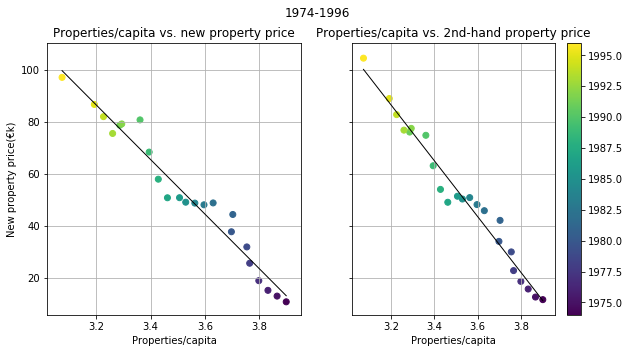

In [56]:
start_year, end_year = '1974', '1996'

lin_reg = LinearRegression()
X, y = df_c.loc[start_year:end_year, 'house_pc_fill'].reshape(-1, 1), df_c.loc[start_year:end_year, 'Dublin_n'].reshape(-1, 1)
lin_reg.fit(X, y)
prediction_space = np.linspace(min(X), max(X)).reshape(-1,1)
y_pred = lin_reg.predict(prediction_space)
print(lin_reg.score(X, y), lin_reg.coef_)
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10, 5))

plt.suptitle(start_year + '-' + end_year)

ax1.scatter(x=df_c.loc[start_year:end_year, 'house_pc_fill'], y=df_c.loc[start_year:end_year, 'Dublin_n'], c=df_c.loc[start_year:end_year].index)
ax1.plot(prediction_space, y_pred, color='black', linewidth=1)
ax1.set_xlabel('Properties/capita')
ax1.set_ylabel('New property price(€k)')
ax1.set_title('Properties/capita vs. new property price')
ax1.grid()
X, y = df_c.loc[start_year:end_year, 'house_pc_fill'].reshape(-1, 1), df_c.loc[start_year:end_year, 'Dublin_s'].reshape(-1, 1)
lin_reg.fit(X, y)
prediction_space = np.linspace(min(X), max(X)).reshape(-1,1)
y_pred = lin_reg.predict(prediction_space)
print(lin_reg.score(X, y), lin_reg.coef_)
im =ax2.scatter(x=df_c.loc[start_year:end_year, 'house_pc_fill'], y=df_c.loc[start_year:end_year, 'Dublin_s'], c=df_c.loc[start_year:end_year].index)
ax2.plot(prediction_space, y_pred, color='black', linewidth=1)
ax2.set_xlabel('Properties/capita')
ax2.set_title('Properties/capita vs. 2nd-hand property price')
ax2.grid()
f.colorbar(im)
plt.show()

C:\Users\Michael\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


0.989770171731 [[-852.19089492]]


C:\Users\Michael\Anaconda3\lib\site-packages\ipykernel\__main__.py:19: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


0.984539200897 [[-1134.26597839]]


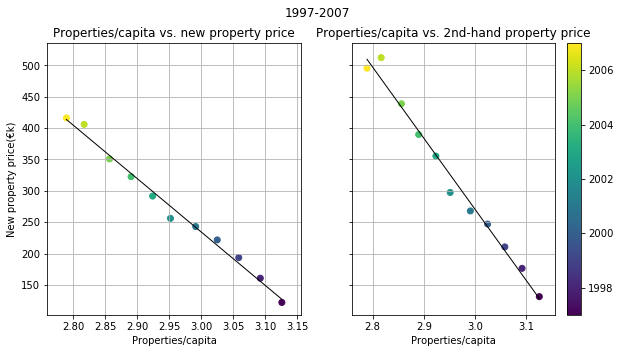

In [58]:
start_year, end_year = '1997', '2007'

lin_reg = LinearRegression()
X, y = df_c.loc[start_year:end_year, 'house_pc_fill'].reshape(-1, 1), df_c.loc[start_year:end_year, 'Dublin_n'].reshape(-1, 1)
lin_reg.fit(X, y)
prediction_space = np.linspace(min(X), max(X)).reshape(-1,1)
y_pred = lin_reg.predict(prediction_space)
print(lin_reg.score(X, y), lin_reg.coef_)
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10, 5))

plt.suptitle(start_year + '-' + end_year)

ax1.scatter(x=df_c.loc[start_year:end_year, 'house_pc_fill'], y=df_c.loc[start_year:end_year, 'Dublin_n'], c=df_c.loc[start_year:end_year].index)
ax1.plot(prediction_space, y_pred, color='black', linewidth=1)
ax1.set_xlabel('Properties/capita')
ax1.set_ylabel('New property price(€k)')
ax1.set_title('Properties/capita vs. new property price')
ax1.grid()
X, y = df_c.loc[start_year:end_year, 'house_pc_fill'].reshape(-1, 1), df_c.loc[start_year:end_year, 'Dublin_s'].reshape(-1, 1)
lin_reg.fit(X, y)
prediction_space = np.linspace(min(X), max(X)).reshape(-1,1)
y_pred = lin_reg.predict(prediction_space)
print(lin_reg.score(X, y), lin_reg.coef_)
im =ax2.scatter(x=df_c.loc[start_year:end_year, 'house_pc_fill'], y=df_c.loc[start_year:end_year, 'Dublin_s'], c=df_c.loc[start_year:end_year].index)
ax2.plot(prediction_space, y_pred, color='black', linewidth=1)
ax2.set_xlabel('Properties/capita')
ax2.set_title('Properties/capita vs. 2nd-hand property price')
ax2.grid()
f.colorbar(im)
plt.show()

C:\Users\Michael\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


0.112148670023


C:\Users\Michael\Anaconda3\lib\site-packages\ipykernel\__main__.py:19: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


0.226393932676


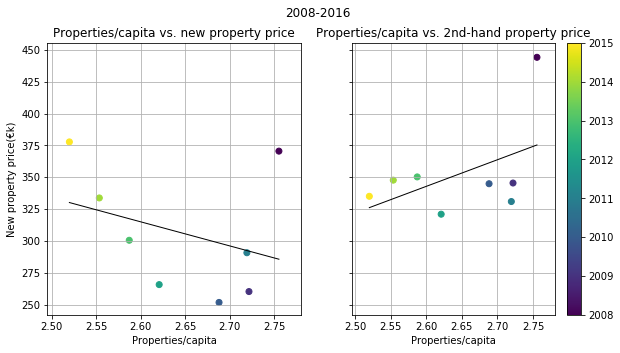

In [60]:
start_year, end_year = '2008', '2016'

lin_reg = LinearRegression()
X, y = df_c.loc[start_year:end_year, 'house_pc_fill'].reshape(-1, 1), df_c.loc[start_year:end_year, 'Dublin_n'].reshape(-1, 1)
lin_reg.fit(X, y)
prediction_space = np.linspace(min(X), max(X)).reshape(-1,1)
y_pred = lin_reg.predict(prediction_space)
print(lin_reg.score(X, y))
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10, 5))

plt.suptitle(start_year + '-' + end_year)

ax1.scatter(x=df_c.loc[start_year:end_year, 'house_pc_fill'], y=df_c.loc[start_year:end_year, 'Dublin_n'], c=df_c.loc[start_year:end_year].index)
ax1.plot(prediction_space, y_pred, color='black', linewidth=1)
ax1.set_xlabel('Properties/capita')
ax1.set_ylabel('New property price(€k)')
ax1.set_title('Properties/capita vs. new property price')
ax1.grid()
X, y = df_c.loc[start_year:end_year, 'house_pc_fill'].reshape(-1, 1), df_c.loc[start_year:end_year, 'Dublin_s'].reshape(-1, 1)
lin_reg.fit(X, y)
prediction_space = np.linspace(min(X), max(X)).reshape(-1,1)
y_pred = lin_reg.predict(prediction_space)
print(lin_reg.score(X, y))
im = ax2.scatter(x=df_c.loc[start_year:end_year, 'house_pc_fill'], y=df_c.loc[start_year:end_year, 'Dublin_s'], c=df_c.loc[start_year:end_year].index)
ax2.plot(prediction_space, y_pred, color='black', linewidth=1)
ax2.set_xlabel('Properties/capita')
ax2.set_title('Properties/capita vs. 2nd-hand property price')
ax2.grid()
f.colorbar(im)
plt.show()

For the period 1974-1996 and 1997-2007 the relationship is highly linear, with all fits obtaining r^2 values of 98% or higher. 

For the period 2008-2015, there does seem to be a linear relationship again emerging in the new property market, in the more recent years (we illustrate this below), however there is no discernible linear relationship in the second-hand property market.

At the outset, we asked two questions: 'is the recent rise in property prices being driven primarily by demand?' and, 'are we in a property bubble'.

The highly non-linear relationship between second-hand property prices and properties/capita would suggest that the answer to the first question is no, although there is a somewhat linear relationship in the new property market in recent years.

To answer the second question, we shall now include some additional indicators.

C:\Users\Michael\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


0.995811385931 [[-1098.55165287]]


C:\Users\Michael\Anaconda3\lib\site-packages\ipykernel\__main__.py:19: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


0.144906164149 [[-117.88434377]]


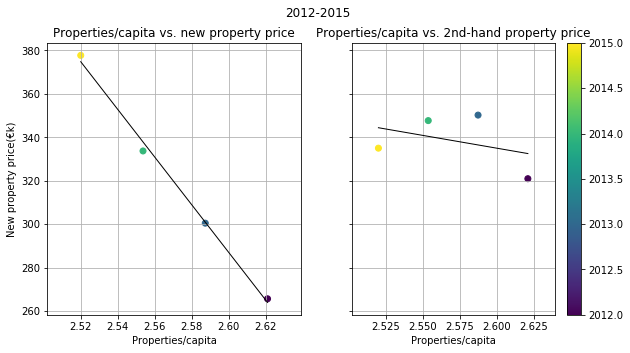

In [62]:
start_year, end_year = '2012', '2015'

lin_reg = LinearRegression()
X, y = df_c.loc[start_year:end_year, 'house_pc_fill'].reshape(-1, 1), df_c.loc[start_year:end_year, 'Dublin_n'].reshape(-1, 1)
lin_reg.fit(X, y)
prediction_space = np.linspace(min(X), max(X)).reshape(-1,1)
y_pred = lin_reg.predict(prediction_space)
print(lin_reg.score(X, y), lin_reg.coef_)
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10, 5))

plt.suptitle(start_year + '-' + end_year)

ax1.scatter(x=df_c.loc[start_year:end_year, 'house_pc_fill'], y=df_c.loc[start_year:end_year, 'Dublin_n'], c=df_c.loc[start_year:end_year].index)
ax1.plot(prediction_space, y_pred, color='black', linewidth=1)
ax1.set_xlabel('Properties/capita')
ax1.set_ylabel('New property price(€k)')
ax1.set_title('Properties/capita vs. new property price')
ax1.grid()
X, y = df_c.loc[start_year:end_year, 'house_pc_fill'].reshape(-1, 1), df_c.loc[start_year:end_year, 'Dublin_s'].reshape(-1, 1)
lin_reg.fit(X, y)
prediction_space = np.linspace(min(X), max(X)).reshape(-1,1)
y_pred = lin_reg.predict(prediction_space)
print(lin_reg.score(X, y), lin_reg.coef_)
im = ax2.scatter(x=df_c.loc[start_year:end_year, 'house_pc_fill'], y=df_c.loc[start_year:end_year, 'Dublin_s'], c=df_c.loc[start_year:end_year].index)
ax2.plot(prediction_space, y_pred, color='black', linewidth=1)
ax2.set_xlabel('Properties/capita')
ax2.set_title('Properties/capita vs. 2nd-hand property price')
ax2.grid()
f.colorbar(im)
plt.show()

# Are we in a housing bubble?

The 5 signs of a housing bubble, according to https://www.forbes.com/sites/trulia/2016/11/15/signs-your-local-real-estate-market-is-a-bubble/#7501aa4b7744, are:

* shaky loans are common
* there's a lot of leverage (i.e. downpayments are small)
* house prices are rising faster than salaries
* reliance on foreign demand
* interest rates are low

http://www.cso.ie/px/pxeirestat/statire/SelectVarVal/Define.asp?MainTable=CIA01&PLanguage=0&PXSId=0#

http://www.cso.ie/px/pxeirestat/statire/SelectVarVal/Define.asp?MainTable=FIM08&PLanguage=0&PXSId=0

# Future directions

* consider the rental sector
* sort out ambiguity between Dublin city and county
* combined new/second-hand figures
* 'fill in' intermediate population figures
* number of people per household
* think about why the relationship between house price and properties per capita has changed -> shift to rental market?
* #transaction in each sector